In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)
import matplotlib

from scipy import signal
from scipy.signal import resample
from scipy.ndimage import zoom

### for endo or exo

In [2]:
def align_slow(eeg, case, fs):
    if 'endo' in case:
        jump_from, jump_to = int((1.5+1+0.5)*fs), int((1.5+1+1)*fs)
    elif 'exo' in case:
        jump_from, jump_to = int((1.5+0.033*4+0.5)*fs), int((1.5+0.033*4+1)*fs)
    
    for channel in range(len(eeg)):
        eeg[channel] = np.concatenate((eeg[channel][:,:jump_from], eeg[channel][:,jump_to:]), axis=1)
        
    return eeg

case_title = 'endo' # switch 'endo' or 'exo' HERE!
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+0.2, 1.5+1+1+0.05+0.2]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+0.2, 1.5+0.033*4+1+0.05+0.2]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None
    lowpass = None

    sb, sa, rb, ra = fe.pipeline_bpdata_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=1)
    
    if 'slow' in case:
        # sham_before_slow = align_slow(sb, case, fs)
        # sham_after_slow = align_slow(sa, case, fs)
        # real_before_slow = align_slow(rb, case, fs)
        # real_after_slow = align_slow(ra, case, fs)

        sham_before_slow = sb
        sham_after_slow = sa
        real_before_slow = rb
        real_after_slow = ra

    else:
        sham_before_fast = sb
        sham_after_fast = sa
        real_before_fast = rb
        real_after_fast = ra

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\eeg_analysis\funcs4eeg.py:181: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  evoked = epochs.get_data()
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\eeg_analysis\funcs4eeg.py:181: FutureWarning:

In [34]:
freq_bands = [[4, 8], [8, 12], [12, 30], [30, 46]]
# exclude fixation
endo_fast_interval = [1.5+1, 1.5+1+0.5]
# endo_slow_interval = [1.5+1, 1.5+1+0.5+0.05+0.2]
endo_slow_interval = [1.5+1, 1.5+1+1]
exo_fast_interval = [1.5+0.033*4, 1.5+0.033*4+0.5]
# exo_slow_interval = [1.5+0.033*4, 1.5+0.033*4+0.5]
exo_slow_interval = [1.5+0.033*4, 1.5+0.033*4+1]

if 'endo' in case_title:
    intervals = [endo_fast_interval, endo_slow_interval]
else:
    intervals = [exo_fast_interval, exo_slow_interval]

origin_slow_sessions = [sham_before_slow, sham_after_slow, real_before_slow, real_after_slow] # 4 sessions * y subjects * (z trials * 32 channels * timepoints)
origin_fast_sessions = [sham_before_fast, sham_after_fast, real_before_fast, real_after_fast]

In [36]:
slow_sessions, fast_sessions = [None]*4, [None]*4
for i, session in enumerate(origin_slow_sessions): # session in shape: y subjects * (z trials * 32 channels * timepoints)
    tmp = session[0] # tmp in shape: z trials * 32 channels * timepoints
    for j in range (1, len(session)):
        tmp = np.concatenate((tmp, session[i])) # session[i] in shape: z trials * 32 channels * timepoints
    slow_sessions[i] = tmp

for i, session in enumerate(origin_fast_sessions):
    tmp = session[0]
    for j in range (1, len(session)):
        tmp = np.concatenate((tmp, session[i]))
    fast_sessions[i] = tmp

# times 1e6
for i in range(4):
    slow_sessions[i] = slow_sessions[i] * 1e6
    fast_sessions[i] = fast_sessions[i] * 1e6

print(slow_sessions[0].shape, slow_sessions[1].shape, slow_sessions[2].shape, slow_sessions[3].shape)
print(fast_sessions[0].shape, fast_sessions[1].shape, fast_sessions[2].shape, fast_sessions[3].shape)
# 1.7s

(168, 32, 4501) (270, 32, 4501) (262, 32, 4501) (218, 32, 4501)
(189, 32, 3901) (262, 32, 3901) (246, 32, 3901) (211, 32, 3901)


In [77]:
bp_data = [np.empty(()),np.empty(()),np.empty(()),np.empty(())] # 4 sessions, xx trials, 32 channels, 4 freq bands
count = 0
for i in range(4):
    fast_session = fast_sessions[i]
    slow_session = slow_sessions[i]
    one_session = np.empty((fast_sessions[i].shape[0]+slow_sessions[i].shape[0],32,4))
    # print(one_session.shape)
    for j, data in enumerate([fast_session, slow_session]): # data: trials x channels x time
        interval = intervals[j]
        t_start, t_end = int(interval[0]*fs), int(interval[1]*fs)
        trial_count = j*fast_session.shape[0]-1
        for trial in range(data.shape[0]):
            trial_count += 1
            one_trial = np.empty((32,4))  
            psds, freqs = mne.time_frequency.psd_array_multitaper(data[trial,:,t_start:t_end], fs, fmin=1, fmax=51, verbose=False)
            # print(psds.max())
            for k, band in enumerate(freq_bands):
                bp = fe.band_power(psds, freqs, band)
                # if bp.min() < 100:
                #     print('session:', i, 'trial:', trial, 'band:', band, 'min:', bp.min())
                #     count += 1
                # if i==2 & trial==75 & j==0:
                #     print(bp)
                one_trial[:,k] = bp
            # print(trial_count)
            one_session[trial_count,:,:] = one_trial # one_session[trial_count,:,:] in shape: 32 channels * 4 freq bands
    bp_data[i] = one_session

print(count)
#

0


In [69]:
a = bp_data[0]

In [162]:
import numpy as np

# Example data, replace this with your actual data array
data = bp_data[0]

# Set the value of k
k = 1000  # This can be adjusted based on how strict you want the outlier detection to be

# Function to detect and remove rows with outliers
def remove_outliers(data, k):
    # Calculate Q1, Q3, and IQR for each element position in the (32, 4) matrices
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1

    # Calculate the outlier thresholds
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR

    # Create a mask that identifies rows with any outliers
    outlier_mask = (data < lower_bound) | (data > upper_bound)

    # Reduce the outlier mask to find rows that contain at least one outlier
    # We use 'any' across the last two dimensions (32, 4)
    rows_with_outliers = outlier_mask.any(axis=(1, 2))

    # Filter the data to keep only rows without any outliers
    filtered_data = data[~rows_with_outliers]

    return filtered_data

# Apply the function
filtered_data = remove_outliers(data, k)

print("Original shape:", data.shape)
print("Filtered shape:", filtered_data.shape)


Original shape: (357, 32, 4)
Filtered shape: (346, 32, 4)


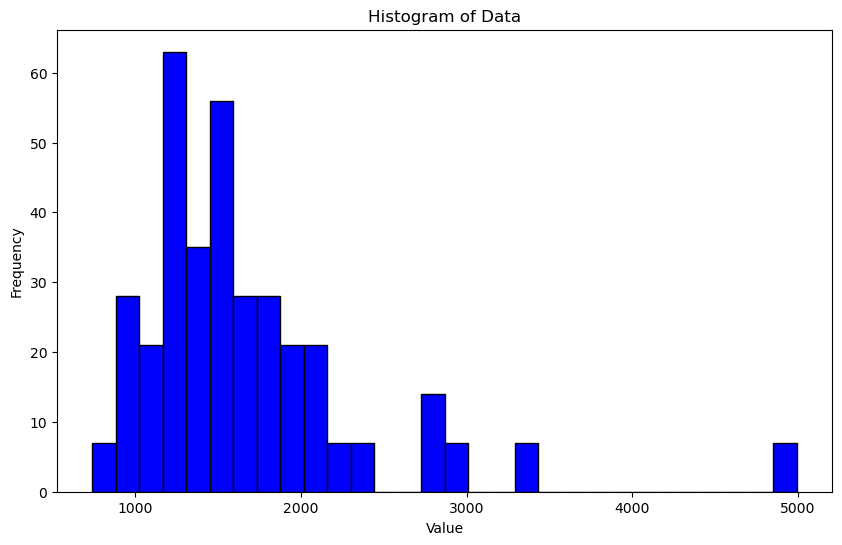

In [75]:
data = bp_data[0][:,12,3]

# Assuming `data` is your numpy array with 327 elements
# For demonstration, I'll generate random data. Replace this with your actual data array.
# Create the histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(data, bins=30, color='blue', edgecolor='black')  # Bins can be adjusted based on your data distribution
plt.title('Histogram of Data')  # Title of the histogram
plt.xlabel('Value')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
# Show the plot
plt.show()


In [164]:
def channel_pos():
    eeg_data = np.zeros((32, 2))
    # get placement data of standard 10-20 system
    montage_1020 = mne.channels.make_standard_montage('standard_1020')
    positions_1020 = montage_1020._get_ch_pos()
    ch_names = ['Fp1', 'Fp2', 'AF3', 'AF4', 'F7', 'F3', 'Fz', 'F4', 'F8',
                'FC1', 'FC2', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 
                'CP2', 'CP6', 'P7', 'P5', 'P3', 'Pz', 'P4', 'P6', 'P8',
                'PO3', 'PO4', 'O1', 'Oz', 'O2']
    ch_types = ['eeg'] * 32
    info = mne.create_info(ch_names, sfreq=1200, ch_types=ch_types, verbose=False)
    raw = mne.io.RawArray(eeg_data, info, verbose=False)

    elec_coords = {ch: positions_1020[ch] for ch in ch_names}
    montage = mne.channels.make_dig_montage(elec_coords, coord_frame='head')
    raw.set_montage(montage)
    
    # Extract the 3D coordinates
    pos = np.stack([raw.info['dig'][i]['r'] for i in range(len(raw.info['dig'])) if raw.info['dig'][i]['kind'] == mne.io.constants.FIFF.FIFFV_POINT_EEG])
    
    # Calculate the distance matrix
    from scipy.spatial import distance_matrix
    dist_matrix = distance_matrix(pos, pos)
    
    # Define adjacency based on distance threshold
    threshold = np.percentile(dist_matrix, 10)  # 10th percentile of distances as threshold
    adjacency_matrix = dist_matrix < threshold
    
    return adjacency_matrix

adjacency = channel_pos()

In [165]:
import numpy as np
from scipy.sparse import csr_matrix

# Example boolean adjacency matrix (replace this with your actual matrix)
adjacency = np.random.choice([True, False], size=(32, 32), p=[0.1, 0.9])

# Convert the boolean adjacency matrix to a CSR sparse matrix
sparse_adjacency_matrix = csr_matrix(adjacency)

# # Print the CSR matrix
# print("CSR Matrix:")
# print(sparse_adjacency_matrix)

# # Optionally, to see the dense form of the matrix (mainly for verification), you can convert it back to an array:
# print("\nDense Array from CSR Matrix:")
# print(sparse_adjacency_matrix.toarray())


In [166]:
from mne.stats import permutation_cluster_test

# Define conditions to compare
condition1 = bp_data[0][:,:,1] # 1=alpha
condition2 = bp_data[1][:,:,1]


# T-test
t_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
    [condition1, condition2], n_permutations=1024, adjacency=sparse_adjacency_matrix, tail=0)

# Find significant clusters
good_cluster_inds = np.where(cluster_p_values < 0.05)[0]

print("Good clusters:", good_cluster_inds)
for i, cluster_ind in enumerate(good_cluster_inds):
    cluster = clusters[cluster_ind]
    print(f"Cluster {i}, p-value: {cluster_p_values[cluster_ind]}")
    print("Electrodes in cluster:", np.where(cluster)[0])  # indices of electrodes in the cluster


Using a threshold of 3.851964
stat_fun(H1): min=0.000363 max=1.612742
Running initial clustering …
Found 0 clusters
Good clusters: []


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_3236\3830449367.py:9: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_3236\3830449367.py:9: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


In [167]:


# Create EvokedArray objects for each condition
evoked_data = [mne.EvokedArray(data, info) for data in bp_data]

# Define conditions to compare
condition1 = evoked_data[0].data
condition2 = evoked_data[1].data

# T-test
t_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
    [condition1, condition2], n_permutations=1000, adjacency=adjacency, tail=0)

# Find significant clusters
good_cluster_inds = np.where(cluster_p_values < 0.05)[0]

print("Good clusters:", good_cluster_inds)
for i, cluster_ind in enumerate(good_cluster_inds):
    cluster = clusters[cluster_ind]
    print(f"Cluster {i}, p-value: {cluster_p_values[cluster_ind]}")
    print("Electrodes in cluster:", np.where(cluster)[0])  # indices of electrodes in the cluster


NameError: name 'info' is not defined

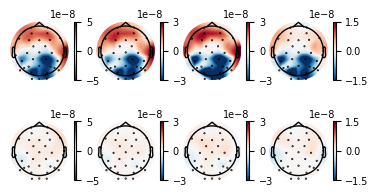

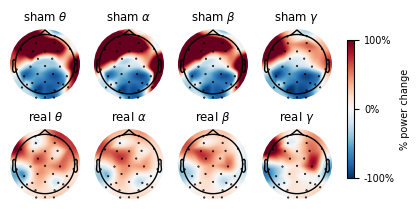

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

bp_subtracts = np.zeros((2, 32, 4))
bp_subtracts_norm = np.zeros((2, 32, 4))
bp_subtracts[0,:,:] = bp_table[1,:,:] - bp_table[0,:,:]
bp_subtracts[1,:,:] = bp_table[3,:,:] - bp_table[2,:,:]
bp_subtracts_norm[0,:,:] = bp_subtracts[0,:,:] / bp_table[0,:,:]
bp_subtracts_norm[1,:,:] = bp_subtracts[1,:,:] / bp_table[2,:,:]

raw = fe.channel_pos()

band_names = ['$\u03B8$', '$\u03B1$', '$\u03B2$', '$\u03B3$']
group_names = ['sham', 'real']

cm = 1/2.54
fig, axes = plt.subplots(nrows=len(group_names), ncols=len(band_names), figsize=(9.4*cm, 5*cm))
cbar_lim = [(-5e-8, 5e-8), (-3e-8, 3e-8), (-3e-8, 3e-8), (-1.5e-8, 1.5e-8)]

for k, band_name in enumerate(band_names):
    for i, group_name in enumerate(group_names):
        ax = axes[i, k]  # Get the correct axis from the grid
        im, cn = mne.viz.plot_topomap(bp_subtracts[i,:,k], pos=raw.info, axes=ax, show=False, contours=0, vlim=cbar_lim[k])
        # Add title to each subplot
        # ax.set_title(group_name + ' ' + band_name)

        # Create an axis for the color bar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        
        # Add the color bar to the current subplot
        cbar = plt.colorbar(im, cax=cax, orientation='vertical')
        cbar.set_ticks([cbar_lim[k][0], 0, cbar_lim[k][1]])


# fig.suptitle(case_title, fontsize=20, y=1.08)
matplotlib.rcParams.update({'font.size': 7})
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.89, top=0.94)
plt.subplots_adjust(wspace=0.3)
# plt.tight_layout()
save_path = os.path.join('..', '..', '..', '..', 'paper', 'Figure 4', case_title+'_topos.eps')
plt.savefig(save_path, format='eps')
plt.show()

cm = 1/2.54
fig, axes = plt.subplots(nrows=len(group_names), ncols=len(band_names), figsize=(9.4*cm, 5*cm))
cbar_lim = (-1, 1)

for k, band_name in enumerate(band_names):
    for i, group_name in enumerate(group_names):
        ax = axes[i, k]  # Get the correct axis from the grid
        im, cn = mne.viz.plot_topomap(bp_subtracts_norm[i,:,k], pos=raw.info, axes=ax, show=False, contours=0, vlim=cbar_lim)
        # Add title to each subplot
        ax.set_title(group_name + ' ' + band_name)

# Add a colorbar to the right of the subplots grid
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['-100%', '0%', '100%'])
cbar.set_label('% power change')
# fig.suptitle(case_title + ', by %', fontsize=20, y=1.1)
matplotlib.rcParams.update({'font.size': 7})
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.88, top=0.94)
save_path = os.path.join('..', '..', '..', '..', 'paper', 'Figure S3', case_title+'_topos_norm.eps')
# plt.savefig(save_path, format='eps')
plt.show()